## Import libraries

In [1]:
!pip install wfdb

import os
import pandas as pd
import numpy as np
import wfdb
from scipy.signal import resample
from scipy.signal import decimate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 33.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [3]:
!wget -r -N -c -np https://physionet.org/files/noneeg/1.0.0/ -P /content/data

--2025-05-09 13:13:14--  https://physionet.org/files/noneeg/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/data/physionet.org/files/noneeg/1.0.0/index.html’

physionet.org/files     [ <=>                ]  13.06K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-05-09 13:13:15 (272 MB/s) - ‘/content/data/physionet.org/files/noneeg/1.0.0/index.html’ saved [13374]

Loading robots.txt; please ignore errors.
--2025-05-09 13:13:15--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘/content/data/physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2025-05-09 13:13:15 (13.4 MB/s) - ‘/content/data/phy

Define the data directory

In [4]:
DATA_DIR = "/content/data/physionet.org/files/noneeg/1.0.0/"
num_subjects = 20

Function to extract information from the header file of each subject

In [5]:
def parse_header_file(header_path):

    metadata = {}

    with open(header_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith("#"):
                key_value = line[2:].split(": ")
                if len(key_value) == 2:
                    key, value = key_value
                    metadata[key] = value
            # Extract the number of samples and sampling frequency from the first line
            elif len(line.split()) == 4 and line.split()[1].isdigit():
                parts = line.split()
                metadata["Number of Samples"] = int(parts[3])
                metadata["Sampling Frequency"] = float(parts[2])

            else:
                parts = line.split()
                if len(parts) > 8 and ".dat" in parts[0]:
                    signal_name = parts[-1]


    return metadata


parse_header_file(os.path.join(DATA_DIR, f"Subject1_AccTempEDA.hea"))

{'Number of Samples': 18343,
 'Sampling Frequency': 8.0,
 'age': '30',
 'gender': 'M',
 'height/cm': '177',
 'weight/kg': '94'}

Function to load the signals

In [6]:
# Example subject
subject_id = 1
record_path = os.path.join(DATA_DIR, f"Subject{subject_id}_AccTempEDA")

# Read the annotations for the subject
annotation_path = os.path.join(DATA_DIR, f"Subject{subject_id}_AccTempEDA")
annotations = wfdb.rdann(annotation_path, 'atr')

# Print the annotations to see the available attributes
print(annotations.__dict__)  # Print all available attributes of the annotations

{'record_name': 'Subject1_AccTempEDA', 'extension': 'atr', 'sample': array([    1,  2401,  5026,  7427,  7748, 10661, 13062, 15943]), 'symbol': ['"', '"', '"', '"', '"', '"', '"', '"'], 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0]), 'chan': array([0, 0, 0, 0, 0, 0, 0, 0]), 'num': array([0, 0, 0, 0, 0, 0, 0, 0]), 'aux_note': ['Relax', 'PhysicalStress', 'Relax', 'EmotionalStress', 'CognitiveStress', 'Relax', 'EmotionalStress', 'Relax'], 'fs': 8, 'label_store': None, 'description': None, 'custom_labels': None, 'contained_labels': None, 'ann_len': 8}


Create a dataframe containing the information of a sebject in the dataset.

In [7]:
def load_signal(subject_id):
  record_pathEDA = os.path.join(DATA_DIR, f"Subject{subject_id}_AccTempEDA")
  record_pathSpO2HR = os.path.join(DATA_DIR, f"Subject{subject_id}_SpO2HR")

  # Extract the metadata and scaling factors
  metadataEDA = parse_header_file(record_pathEDA + ".hea")
  metadataSpO2HR = parse_header_file(record_pathSpO2HR + ".hea")

  # Read signal data
  signalsEDA, fieldsEDA = wfdb.rdsamp(record_pathEDA)
  signalsSpO2HR, fieldsSpO2HR = wfdb.rdsamp(record_pathSpO2HR)

  # Convert the signals to a dataframe
  df1 = pd.DataFrame(signalsEDA, columns=['ax', 'ay', 'az', 'temp', 'EDA'])
  df2 = pd.DataFrame(signalsSpO2HR, columns=['SpO2', 'HR'])

  # Read the annotations (task stages)
  annotation_pathEDA = os.path.join(DATA_DIR, f"Subject{subject_id}_AccTempEDA")
  annotationsEDA = wfdb.rdann(annotation_path, 'atr')

  # Determine sampling rates from metadata
  fs_eda = int(metadataEDA['Number of Samples'])  # AccTempEDA frequency
  fs_spo2 = int(metadataSpO2HR['Number of Samples'])  # SpO2HR frequency

  # Compute downsampling factor
  downsample_factor = fs_eda // fs_spo2  # Assuming fs_eda is a multiple of fs_spo2

  # Repeat each SpO2 and HR value by the downsampling factor
  df2_repeated = df2.loc[df2.index.repeat(downsample_factor)].reset_index(drop=True)

  # Ensure the repeated df2 matches the length of df1
  min_len = min(len(df1), len(df2_repeated))
  df1 = df1.iloc[:min_len].reset_index(drop=True)
  df2_repeated = df2_repeated.iloc[:min_len].reset_index(drop=True)

  # Combine signals
  df = pd.concat([df1, df2_repeated], axis=1)

  metadata = {**metadataEDA, **metadataSpO2HR}

  # Initialize the list to store task stages
  task_stages = [''] * len(df)

  # Loop through the annotations and assign task stages
  for i in range(len(annotations.sample) - 1):  # Loop through each annotation
      start_idx = annotations.sample[i]-1
      end_idx = annotations.sample[i + 1]
      task_stage = annotations.aux_note[i]

      # Assign the task stage to all samples between start_idx and end_idx
      task_stages[start_idx:end_idx] = [task_stage] * (end_idx - start_idx)

  # For the last annotation, assign the task stage to the remaining samples
  if len(annotations.sample) > 0:
      start_idx = annotations.sample[-1]
      task_stage = annotations.aux_note[-1]
      task_stages[start_idx:] = [task_stage] * (len(df) - start_idx)

  df['task'] = task_stages



  return df




Combine the data from all subjects into one large dataframe.

In [8]:
all_subjects = []
for subject_id in range(1, num_subjects + 1):
    df = load_signal(subject_id)
    df["subject_id"] = subject_id
    all_subjects.append(df)

# Merge into one DataFrame
final_df = pd.concat(all_subjects, ignore_index=True)

final_df

,ax,ay,az,temp,EDA,SpO2,HR,task,subject_id
0,0.760015,-0.869990,-0.100004,30.100043,0.083039,96.999969,89.000763,Relax,1
1,0.770025,-0.869990,-0.110031,30.100043,0.081028,96.999969,89.000763,Relax,1
2,0.750005,-0.869990,-0.100004,30.100043,0.081028,96.999969,89.000763,Relax,1
3,0.770025,-0.869990,-0.100004,30.100043,0.079018,96.999969,89.000763,Relax,1
4,0.750005,-0.869990,-0.100004,30.100043,0.081028,96.999969,89.000763,Relax,1
...,...,...,...,...,...,...,...,...,...
323598,0.529962,0.289963,0.809974,31.799982,0.488046,97.999939,80.000977,Relax,20
323599,0.539949,0.289963,0.809974,31.599933,0.488046,97.999939,80.000977,Relax,20
323600,0.529962,0.289963,0.809974,31.599933,0.488046,97.999939,80.000977,Relax,20
323601,0.539949,0.299974,0.809974,31.599933,0.487007,97.999939,80.000977,Relax,20


Not necessary, but may be useful if examining the finer differences between the stressed and relaxed states

In [9]:
def label_relaxation_stage(df):
    current_subject = None
    relaxation_counter = 0  # Start at 0 so first increment makes it Relaxation1
    last_task = None

    for index, row in df.iterrows():
        # Detect subject change
        if row['subject_id'] != current_subject:
            current_subject = row['subject_id']
            relaxation_counter = 0  # Reset counter for new subject
            last_task = None  # Reset last task tracking

        if row['task'] == 'Relax':
            if last_task != 'Relax':
                relaxation_counter += 1  # Only increment when entering a new Relaxation phase
            df.at[index, 'task'] = f"Relax{relaxation_counter}"

        last_task = row['task']  # Track previous task

    return df

# Apply this function to your final dataframe
final_df = label_relaxation_stage(final_df)

final_df


,ax,ay,az,temp,EDA,SpO2,HR,task,subject_id
0,0.760015,-0.869990,-0.100004,30.100043,0.083039,96.999969,89.000763,Relax1,1
1,0.770025,-0.869990,-0.110031,30.100043,0.081028,96.999969,89.000763,Relax1,1
2,0.750005,-0.869990,-0.100004,30.100043,0.081028,96.999969,89.000763,Relax1,1
3,0.770025,-0.869990,-0.100004,30.100043,0.079018,96.999969,89.000763,Relax1,1
4,0.750005,-0.869990,-0.100004,30.100043,0.081028,96.999969,89.000763,Relax1,1
...,...,...,...,...,...,...,...,...,...
323598,0.529962,0.289963,0.809974,31.799982,0.488046,97.999939,80.000977,Relax4,20
323599,0.539949,0.289963,0.809974,31.599933,0.488046,97.999939,80.000977,Relax4,20
323600,0.529962,0.289963,0.809974,31.599933,0.488046,97.999939,80.000977,Relax4,20
323601,0.539949,0.299974,0.809974,31.599933,0.487007,97.999939,80.000977,Relax4,20


Turn this into a binary classification problem with two labels (stress, relax)

In [10]:
def combine_stress_relax_labels(df):
    # Define a mapping of task stages to the new "Stress" and "Relax" categories
    # Adjust this dictionary based on your specific task labels
    stress_labels = ['CognitiveStress', 'EmotionalStress', 'PhysicalStress']  # Stress categories
    relax_labels = ['Relax1', 'Relax2', 'Relax3', 'Relax4']  # Relax categories

    # Create a new column 'task_combined' where we combine the labels into 'Stress' and 'Relax'
    df['task_combined'] = df['task'].apply(lambda x: 'Stress' if x in stress_labels else ('Relax' if x in relax_labels else 'Unknown'))

    return df

final_df = combine_stress_relax_labels(final_df)
final_df

,ax,ay,az,temp,EDA,SpO2,HR,task,subject_id,task_combined
0,0.760015,-0.869990,-0.100004,30.100043,0.083039,96.999969,89.000763,Relax1,1,Relax
1,0.770025,-0.869990,-0.110031,30.100043,0.081028,96.999969,89.000763,Relax1,1,Relax
2,0.750005,-0.869990,-0.100004,30.100043,0.081028,96.999969,89.000763,Relax1,1,Relax
3,0.770025,-0.869990,-0.100004,30.100043,0.079018,96.999969,89.000763,Relax1,1,Relax
4,0.750005,-0.869990,-0.100004,30.100043,0.081028,96.999969,89.000763,Relax1,1,Relax
...,...,...,...,...,...,...,...,...,...,...
323598,0.529962,0.289963,0.809974,31.799982,0.488046,97.999939,80.000977,Relax4,20,Relax
323599,0.539949,0.289963,0.809974,31.599933,0.488046,97.999939,80.000977,Relax4,20,Relax
323600,0.529962,0.289963,0.809974,31.599933,0.488046,97.999939,80.000977,Relax4,20,Relax
323601,0.539949,0.299974,0.809974,31.599933,0.487007,97.999939,80.000977,Relax4,20,Relax


Check if there are any missing values

In [11]:
print(final_df['task'].isna().sum())  # Check if there are NaN values
print(final_df[final_df['task'] == ""])  # Check if any tasks are empty strings

0
Empty DataFrame
Columns: [ax, ay, az, temp, EDA, SpO2, HR, task, subject_id, task_combined]
Index: []


Apply min-max normalization

In [12]:
columns_to_normalize = ['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'HR']

final_df[columns_to_normalize] = (final_df[columns_to_normalize] - final_df[columns_to_normalize].min()) / (final_df[columns_to_normalize].max() - final_df[columns_to_normalize].min())

final_df


,ax,ay,az,temp,EDA,SpO2,HR,task,subject_id,task_combined
0,0.524420,0.547013,0.483943,0.477071,0.009078,0.849997,0.476752,Relax1,1,Relax
1,0.526546,0.547013,0.481643,0.477071,0.008859,0.849997,0.476752,Relax1,1,Relax
2,0.522295,0.547013,0.483943,0.477071,0.008859,0.849997,0.476752,Relax1,1,Relax
3,0.526546,0.547013,0.483943,0.477071,0.008639,0.849997,0.476752,Relax1,1,Relax
4,0.522295,0.547013,0.483943,0.477071,0.008859,0.849997,0.476752,Relax1,1,Relax
...,...,...,...,...,...,...,...,...,...,...
323598,0.475577,0.745299,0.692656,0.633030,0.053356,0.899996,0.372103,Relax4,20,Relax
323599,0.477697,0.745299,0.692656,0.614677,0.053356,0.899996,0.372103,Relax4,20,Relax
323600,0.475577,0.745299,0.692656,0.614677,0.053356,0.899996,0.372103,Relax4,20,Relax
323601,0.477697,0.747010,0.692656,0.614677,0.053243,0.899996,0.372103,Relax4,20,Relax


Do a non-overlapping windowed average to reduce noise

In [13]:
import pandas as pd

# Columns to average
signal_cols = ['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'HR']
id_cols = ['subject_id', 'task_combined']
window_size = 10  # Change this to adjust how much you reduce the dataset

# Sort to preserve time order
final_df_sorted = final_df.sort_values(id_cols)

# Function to apply chunked averaging within each group
def downsample_group(group):
    # Truncate group to multiple of window_size
    n = len(group) // window_size * window_size
    group = group.iloc[:n]

    # Reshape and average
    averaged = group[signal_cols].values.reshape(-1, window_size, len(signal_cols)).mean(axis=1)

    # Repeat metadata for each new chunk
    meta = group[id_cols].iloc[::window_size].reset_index(drop=True)

    return pd.concat([meta.reset_index(drop=True),
                      pd.DataFrame(averaged, columns=signal_cols)], axis=1)

# Apply to each subject/task group
downsampled_df = final_df_sorted.groupby(id_cols, group_keys=False).apply(downsample_group).reset_index(drop=True)

downsampled_df

<ipython-input-13-6ed9fdcd3ceb>:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  downsampled_df = final_df_sorted.groupby(id_cols, group_keys=False).apply(downsample_group).reset_index(drop=True)


,subject_id,task_combined,ax,ay,az,temp,EDA,SpO2,HR
0,1,Relax,0.523570,0.546842,0.482793,0.477071,0.008903,0.849997,0.473261
1,1,Relax,0.523145,0.546329,0.482793,0.477071,0.009012,0.849997,0.458142
2,1,Relax,0.522933,0.545987,0.483713,0.477071,0.009034,0.849997,0.453492
3,1,Relax,0.524420,0.547184,0.483253,0.477071,0.009012,0.824997,0.453492
4,1,Relax,0.521238,0.545475,0.483023,0.477071,0.009012,0.799998,0.443029
...,...,...,...,...,...,...,...,...,...
32344,20,Stress,0.485130,0.738461,0.692656,0.673397,0.057948,0.899996,0.151166
32345,20,Stress,0.485555,0.737950,0.692656,0.671563,0.057870,0.899996,0.151166
32346,20,Stress,0.485554,0.738461,0.692656,0.669728,0.057727,0.899996,0.146516
32347,20,Stress,0.485978,0.737950,0.692656,0.669728,0.057594,0.899996,0.139542


In [14]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.random_projection import GaussianRandomProjection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

Split the data into training and test sets and fit using a standard scaler.

In the experiment they found age, height, and weight not to be useful so I haven't included these features.

In [15]:
#feature_columns = ['ax', 'ay', 'az', 'temp', 'EDA', 'age', 'height/cm', 'weight/kg']
feature_columns = ['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2']

X = downsampled_df[feature_columns]
y = downsampled_df['task_combined']


# Split the data into training, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data features using StandardScaler;
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(X_train)
features_test_scaled = scaler.transform(X_test)



### Feature Extraction (checking what features can be removed) ###

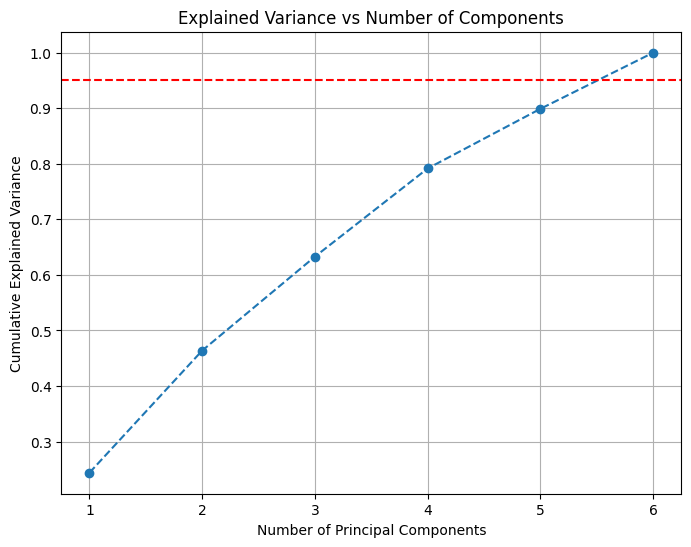

Optimal number of PCA components: 6


In [16]:
# Apply PCA with the maximum number of components (all features)
pca = PCA()
pca.fit(features_train_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()


# Plot the cumulative explained variance to visualize the optimal number of components
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% variance line
plt.grid()
plt.show()

# Find the number of components that explain at least 95% of the variance
optimal_components = (cumulative_variance >= 0.90).argmax() + 1

print(f"Optimal number of PCA components: {optimal_components}")

The optimal number of components is found to be 6 so I'm going to keep all features.

Apply PCA with the optimal number of components and compare to Random Projection

In [17]:
# Apply PCA with the optimal number of components over the train set
pca = PCA(n_components=optimal_components)
features_train_pca = pca.fit_transform(features_train_scaled)
features_test_pca = pca.transform(features_test_scaled)

# transform using Random Projection
rp = GaussianRandomProjection(n_components=optimal_components, random_state=42)
features_train_rp = rp.fit_transform(features_train_scaled)
features_test_rp = rp.transform(features_test_scaled)


# Compare memory efficiency (in KB)
pca_components = pca.components_
pca_mean = pca.mean_
pca_memory_kb = (pca_components.nbytes + pca_mean.nbytes) / 1024

rp_components = rp.components_
rp_memory_kb = rp_components.nbytes / 1024

print(f"PCA memory usage: {pca_memory_kb:.2f} KB")
print(f"Random Projection memory usage: {rp_memory_kb:.2f} KB")
print(f"Memory reduction from PCA to RP: {100 * (1 - rp_memory_kb / pca_memory_kb):.2f}%")

def evaluate(X_tr, X_te, y_tr, y_te, label):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_tr, y_tr)
    preds = clf.predict(X_te)
    acc = accuracy_score(y_te, preds)
    f1 = f1_score(y_te, preds, average='weighted')
    print(f"{label} — Accuracy: {acc:.4f}, F1: {f1:.4f}")
    return acc, X_tr, X_te

print("\nComparing PCA and Random Projection:")
acc_pca, X_train_pca_final, X_test_pca_final = evaluate(features_train_pca, features_test_pca, y_train, y_test, "PCA")
acc_rp, X_train_rp_final, X_test_rp_final = evaluate(features_train_rp, features_test_rp, y_train, y_test, "Random Projection")




PCA memory usage: 0.33 KB
Random Projection memory usage: 0.28 KB
Memory reduction from PCA to RP: 14.29%

Comparing PCA and Random Projection:
PCA — Accuracy: 0.9833, F1: 0.9833
Random Projection — Accuracy: 0.9776, F1: 0.9776


Random Projection and PCA comparison:

PCA has a marginally better accuracy but the difference is not too significant. Would save a lot of space using Random Projection so this is what will be used going forward.

In [18]:
X_train = X_train_rp_final
X_test = X_test_rp_final

In [19]:
# Combine the selected features and labels into DataFrames
df_train_final = pd.DataFrame(data=X_train)
df_train_final['task'] = y_train.reset_index(drop=True)

df_test_final = pd.DataFrame(data=X_test)
df_test_final['task'] = y_test.reset_index(drop=True)

# Display the dimensionality-reduced training set
print("\nFinal Transformed Training Set:")
print(df_train_final)

# Display the dimensionality-reduced test set
print("\nFinal Transformed Test Set:")
print(df_test_final)


Final Transformed Training Set:
              0         1         2         3         4         5    task
0      0.685931 -0.864497  0.400429  1.306835  0.671337 -0.825034  Stress
1      0.547046  0.154205 -0.840597 -0.527611 -0.532758 -0.206419  Stress
2      0.461030 -0.802063  0.154558  2.244448  0.043061 -0.401161  Stress
3      0.095796 -1.154886 -0.220223  2.552951  0.389481  0.606116   Relax
4      0.669508 -0.917088  0.228715  1.199837  0.704040 -0.654929  Stress
...         ...       ...       ...       ...       ...       ...     ...
25874 -0.612596  0.588773  0.573028 -1.507488  1.550203  1.224024  Stress
25875  0.535168  0.233111 -0.660971 -0.432838 -0.729765 -0.876727   Relax
25876 -0.331745  0.706234  0.877029 -2.196161  1.279928  0.101850  Stress
25877  0.384729  0.406975 -1.675516 -0.668347 -0.821779  0.742459  Stress
25878 -0.236787  0.336525 -0.974133 -0.891660 -0.969032  0.204835  Stress

[25879 rows x 7 columns]

Final Transformed Test Set:
             0         1

### Synthetic Data Generation ###



*   Implement Kernel Density Estimation (KDE) and Gaussian Mixture Models (GMM) for synthetic data generation

* Label synthetic data with Random Forest

In [20]:
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture as GMM
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score, f1_score



In [21]:
random_state = 5

Take the test and training data from the reduced dataframes

In [22]:
# Prepare X_train, y_train, X_test, y_test from final reduced-dimension DataFrames
X_train = df_train_final.iloc[:, :-1]
y_train = df_train_final.iloc[:, -1]
X_test = df_test_final.iloc[:, :-1]
y_test = df_test_final.iloc[:, -1]

Implement Kernel Density Estimation

In [23]:
from sklearn.neighbors import KernelDensity

def KDE_sample_generation (X_train, X_validation):

  # search over different bandwidth, find the best one
  bw_list = [0.5, 0.7, 1, 1.5, 2, 3]

  log_like = np.zeros((len(bw_list)))
  for i, bw in enumerate(bw_list):
    print(f"bw = {bw}")

    kernel_density = KernelDensity(kernel='gaussian', bandwidth=bw)
    kernel_density.fit(X_train)
    log_like[i] = kernel_density.score(X_validation)


  bbw = bw_list[np.argmax(log_like)]
  print (f"Best Bandwidth: {bbw}")

  # create model with Best Bandwidth, fit
  kernel_density = KernelDensity(kernel='gaussian', bandwidth=bbw)
  kernel_density.fit(X_train)

  # sample 200000 samples from the model
  X_syn = kernel_density.sample(n_samples=200000, random_state=random_state)
  print(f"X_syn.shape: {X_syn.shape}")

  num_features = X_syn.shape[1]  # Get the number of features from X_syn's shape


  return X_syn

Implement Gaussian Mixture Model (GMM)

In [24]:
# Generating synthetic data based on GMM model - The number of Gaussians is selected based on maximizing
# the sum of the log-probabilities of instances in the validation set
def GMM_sample_generation(X_train, X_validation):
    max_components = 5
    n_components = np.arange(1, max_components, 1)
    sum_array = np.zeros((max_components - 1))
    for i in n_components:

        model = GMM(n_components=i, covariance_type='full', random_state=random_state)
        model.fit(X_train)

        log_likelihoods = model.score_samples(X_validation)
        sum_array[i - 1] = sum(log_likelihoods)
        print(f"Accumulated log likelihood for {i} components:", sum_array[i - 1])

    n_components = np.argmax(sum_array)
    n_components = n_components + 1
    print("Number of components: {}".format(n_components))

    # define and fit the model with best number of components
    gmm = GMM(n_components=n_components, covariance_type='full', random_state=random_state)
    gmm.fit(X_train)

    print(gmm.converged_)

    out = gmm.score(X_validation)
    print(out)

    X_syn = gmm.sample(200000)
    print(X_syn[0].shape)
    return X_syn

In [25]:
def sample_generation (X_train, X_validation, method):
    """supported methods: GMM, KDE"""
    count = 100000
    if method == "GMM":
        X_syn_out = GMM_sample_generation(X_train, X_validation)
        X_syn = X_syn_out[0]
    elif method == "KDE":
        X_syn = KDE_sample_generation(X_train, X_validation)
    else:
        print ("method not supported")
    return X_syn

Generate the synthetic data

(25879, 6)
bw = 0.5
bw = 0.7
bw = 1
bw = 1.5
bw = 2
bw = 3
Best Bandwidth: 0.5
X_syn.shape: (200000, 6)
Accumulated log likelihood for 1 components: -32915.60123704864
Accumulated log likelihood for 2 components: -29980.94340358133
Accumulated log likelihood for 3 components: -25336.799523325575
Accumulated log likelihood for 4 components: -19896.631186629307
Number of components: 4
True
-3.075213475522307
(200000, 6)


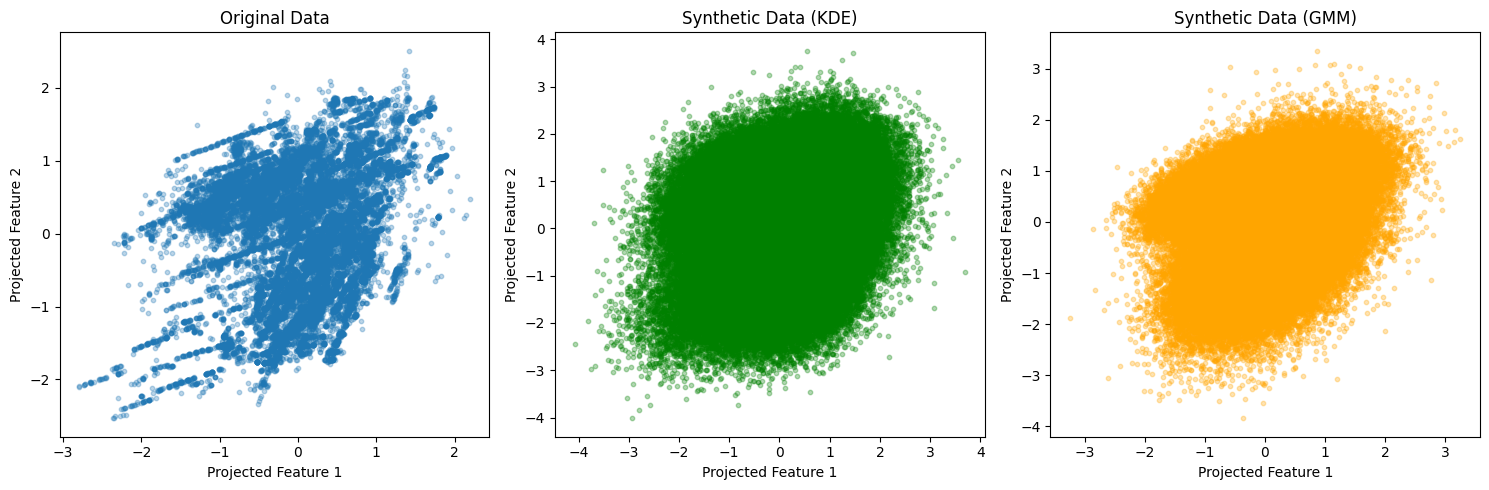

In [26]:
import matplotlib.pyplot as plt

# Assuming these are your PCA-transformed datasets
print(X_train.shape)
X_real = X_train
X_kde = sample_generation(X_real, X_test, method='KDE')
X_gmm = sample_generation(X_real, X_test, method='GMM')

X_real = X_real.values

# Plot first two PCA components directly
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_real[:, 0], X_real[:, 1], alpha=0.3, s=10)
plt.title("Original Data")
plt.xlabel("Projected Feature 1")
plt.ylabel("Projected Feature 2")

plt.subplot(1, 3, 2)
plt.scatter(X_kde[:, 0], X_kde[:, 1], alpha=0.3, s=10, color='green')
plt.title("Synthetic Data (KDE)")
plt.xlabel("Projected Feature 1")
plt.ylabel("Projected Feature 2")

plt.subplot(1, 3, 3)
plt.scatter(X_gmm[:, 0], X_gmm[:, 1], alpha=0.3, s=10, color='orange')
plt.title("Synthetic Data (GMM)")
plt.xlabel("Projected Feature 1")
plt.ylabel("Projected Feature 2")

plt.tight_layout()
plt.show()



Evaluate the similarity of synthetic data to the original data

In [27]:
import numpy as np
from scipy.spatial.distance import cdist

def compute_mmd_rbf(X, Y, gamma=1.0):
    """Compute the MMD between two datasets using an RBF kernel."""
    XX = cdist(X, X, 'sqeuclidean')
    YY = cdist(Y, Y, 'sqeuclidean')
    XY = cdist(X, Y, 'sqeuclidean')

    K_XX = np.exp(-gamma * XX)
    K_YY = np.exp(-gamma * YY)
    K_XY = np.exp(-gamma * XY)

    m = X.shape[0]  # assume X and Y have the same size

    mmd = (K_XX.sum() - np.trace(K_XX)) / (m * (m - 1)) \
        + (K_YY.sum() - np.trace(K_YY)) / (m * (m - 1)) \
        - 2 * K_XY.mean()

    return mmd

In [28]:
# evaluate on a random subset rather than the entire dataset so that it's less data intensive
eval_n = 3000  # or 5000, depending on what fits in memory

idx = np.random.choice(X_real.shape[0], eval_n, replace=False)
X_real_eval = X_real[idx]
X_kde_eval = X_kde[idx]
X_gmm_eval = X_gmm[idx]

mmd_kde = compute_mmd_rbf(X_real_eval, X_kde_eval, gamma=0.5)
mmd_gmm = compute_mmd_rbf(X_real_eval, X_gmm_eval, gamma=0.5)

print("MMD (KDE):", mmd_kde)
print("MMD (GMM):", mmd_gmm)

MMD (KDE): 0.01587513360125764
MMD (GMM): 0.10442553872174745


The best synthetic is generated using the KDE model

In [29]:
X_syn = X_kde
print(X_syn.shape)

(200000, 6)


Train a decision tree on the training data, which will then be used to label the synthetic data.

In [30]:
# Using the Random forest model to label the synthetic data
validation_accs = []
train_accs = []

# go over different max_depth of Random forest
for i in range (1, 30):
  print(f"training Random forest max_depth={i}")
  clf = RandomForestClassifier(n_estimators=500, max_depth=i, criterion='entropy', random_state=random_state)

  # fit the model, and save training accuracy in train_accs, validation accuracy in validation_accs
  clf.fit(X_train, y_train)
  train_accs.append(clf.score(X_train, y_train))
  validation_accs.append(clf.score(X_test, y_test))

training Random forest max_depth=1
training Random forest max_depth=2
training Random forest max_depth=3
training Random forest max_depth=4
training Random forest max_depth=5
training Random forest max_depth=6
training Random forest max_depth=7
training Random forest max_depth=8
training Random forest max_depth=9
training Random forest max_depth=10
training Random forest max_depth=11
training Random forest max_depth=12
training Random forest max_depth=13
training Random forest max_depth=14
training Random forest max_depth=15
training Random forest max_depth=16
training Random forest max_depth=17
training Random forest max_depth=18
training Random forest max_depth=19
training Random forest max_depth=20
training Random forest max_depth=21
training Random forest max_depth=22
training Random forest max_depth=23
training Random forest max_depth=24
training Random forest max_depth=25
training Random forest max_depth=26
training Random forest max_depth=27
training Random forest max_depth=28
t

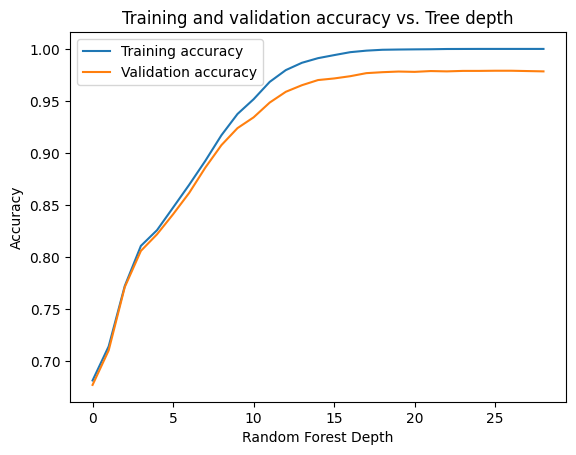

Baseline Random Forest depth=26
train acc=0.9999613586305499
validation acc=0.9789799072642967


In [32]:
plt.title('Training and validation accuracy vs. Tree depth')
plt.plot(train_accs, label='Training accuracy')
plt.plot(validation_accs, label='Validation accuracy')
plt.xlabel("Random Forest Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

best_tree_id = validation_accs.index(max(validation_accs))
best_tree_depth = best_tree_id + 1
print(f"Baseline Random Forest depth={best_tree_depth}")
print(f"train acc={train_accs[best_tree_id]}")
print(f"validation acc={validation_accs[best_tree_id]}")

Label the synthetic data using the decision tree

In [ ]:
# after finding the best depth, we will retrain a random forset with both training and validation data

X_train_total = np.concatenate((X_train, X_test), axis=0)
y_train_total = np.concatenate((y_train, y_test), axis=0)

clf = RandomForestClassifier(n_estimators=350, max_depth=best_tree_depth, criterion='gini', random_state=random_state)
# fit the model with total data, and report training accuracy
clf.fit(X_train_total, y_train_total)
train_acc = clf.score(X_train_total, y_train_total)
print(f"train acc={train_acc}")

# label the synthetic data with current model
y_syn = clf.predict(X_syn)
print(f"y_syn.shape: {y_syn.shape}")

train acc=0.9999690871433429
y_syn.shape: (200000,)


Combine data with the synthetic data

In [ ]:
# Use synthetic data to pretrain the model
X_train = X_syn
y_train = y_syn

# Done with synthetic data — now safe to clear it
del X_syn, y_syn
import gc
gc.collect()


16574

##Find the optimal architecture using SCANN

In [29]:
import random
import torch

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import os
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import shutil

In [30]:
# define some util functions

def neuronMask(mask, add_index, func='in', sparse=False, ratio=0.2):
    if sparse:
        num = int(mask.size(0)*ratio)
        if func == 'in':
            for i in add_index:
                indices = list(range(mask.size(0)))
                np.random.shuffle(indices)
                for j in indices[:num]:
                    mask[j, i] = 1
        elif func == 'out':
            for i in add_index:
                indices = list(range(mask.size(1)))
                np.random.shuffle(indices)
                for j in indices[:num]:
                    mask[i, j] = 1
    else:
        if func == 'in':
            for i in add_index:
	            mask[:, i] = 1
        elif func == 'out':
            for i in add_index:
                mask[i, :] = 1
    return mask


Define the deep neural network

In [31]:
class SDNN(object):
    def __init__(self, in_num, out_num, init_size, max_size, batch_size, scheme= 'A', **kwargs):
        self.in_num = in_num # The number of input features
        self.out_num = out_num # The number of output classes
        self.init_size = init_size # the inital number of hidden neurons
        self.max_size = max_size  # max number of allowed hidden neurons in the architecture
        self.cur_size = init_size - 1  # current size of hidden neurons
        self.batch_size = batch_size # Batch size
        self.name = 'SDNN' # name of the model
        self.flag = 0

        self.epoch = 0
        self.best_acc = 0
        self.best_acc_prune = 0
        self.now_acc = 0
        self.connection_count = 0

        self.scheme = scheme


    # Forward pass
    # we first compute the hidden activations by utilizing the input to hidden weights (w1) , and hidden to hidden weights,
    # (w2) and their corresponding mask matrices (m1, m2), as well as the hidden biases (b1)
    # After computing the hidden activations, we use it alongside hidden to out weight matrix (w3) and corresponding
    # mask (m3), and input to output connections (w4) and its corresponding mask (m4), and output biases (b2)
    # at the end we return the computed output
    def forward(self, x, retain_grad = True):
        self.hidden = torch.zeros(x.size(0), self.max_size)

        for i,j in enumerate(self.active_index):
            self.hidden[:, j] = F.relu((torch.mm(self.hidden.clone(), torch.mul(self.w2[:, j], self.m2[:, j]).view(-1, 1))
                                       + torch.mm(x, torch.mul(self.w1[:, j], self.m1[:, j]).view(-1,1))
                                       + self.b1[:, j])).squeeze(1)

        out = torch.mm(self.hidden, torch.mul(self.w3, self.m3)) \
                  + torch.mm(x, torch.mul(self.w4, self.m4)) \
                  + self.b2

        if retain_grad:
            out.retain_grad()

        return out


    # used in connection growth
    def forwardMask(self, display=True):
        for i,j in enumerate(self.active_index):
            mask_idx = list(set(range(self.max_size)) - set(self.active_index[:i]))
            self.m2.data[:, j][mask_idx] = 0
        if display:
            print('Forward mask, m2: %d' %np.count_nonzero(self.m2.data))


    def backwardGrad(self, outgrad):
        self.hidden.grad = torch.mm(outgrad, torch.t(self.w3))
        rev_idx = np.flip(self.active_index, axis=0)
        for i,j in enumerate(rev_idx):
            for k in range(i):
                self.hidden.grad.data[:, j] = self.hidden.grad.data[:, j] + self.hidden.grad.data[:, k] \
                                                  *self.w2.data[j, k]


    def displayConnection(self, display=True):
        """it shows the number of active weights in m1, m2, m3, and m4 masks"""
        m1 = 0
        m2 = 0
        m3 = 0
        m4 = np.count_nonzero(self.m4.data)
        for i,j in enumerate(self.active_index):
            m1 += np.count_nonzero(self.m1.data[:, j])
            m3 += np.count_nonzero(self.m3.data[j, :])
            for k in range(i):
                m2 += np.count_nonzero(self.m2.data[self.active_index[k]][j])

        if display:
            print('Connection Info: ')
            print('m1: %d, m2: %d, m3: %d, m4: %d' %(m1,m2,m3,m4))
            print('Total: %d' % (m1+m2+m3+m4))
        return m1, m2, m3, m4, m1+m2+m3+m4


    def save_checkpoint(self, state, is_best, folder_to_save, filename = '_checkpoint.pth.tar'):
        name_to_save = os.path.join(folder_to_save, self.name + filename)
        torch.save(state, name_to_save)
        if is_best:
            shutil.copyfile(name_to_save, os.path.join(folder_to_save, self.name + '_model_best.pth.tar'))
            print(f"also saved as the best checkpoint to {os.path.join(folder_to_save, self.name + '_model_best.pth.tar')}")

Function to load the training data that we will use to learn the architcture and the test data used to evaluate everything

In [32]:
def load_data_train(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    y_train = np.where(y_train == 'Relax', 0, np.where(y_train == 'Stress', 1, y_train)).astype(int)
    y_test = np.where(y_test == 'Relax', 0, np.where(y_test == 'Stress', 1, y_test)).astype(int)

    return X_train, y_train, X_test, y_test


In [33]:
import numpy as np
import torch

def to_numpy_safe(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

def loadData(self, X_train, y_train, X_test, y_test, mode='train', fold=None):
    if mode == 'train':
        # Ensure inputs are NumPy arrays
        X_train = to_numpy_safe(X_train)
        y_train = to_numpy_safe(y_train)

        self.X_train, self.y_train, self.X_validation, self.y_validation = load_data_train(X_train, y_train)

        self.X_train = torch.tensor(self.X_train, dtype=torch.float32)
        self.y_train = torch.tensor(self.y_train.reshape(-1), dtype=torch.long)

        self.X_validation = torch.tensor(self.X_validation, dtype=torch.float32)
        self.y_validation = torch.tensor(self.y_validation.reshape(-1), dtype=torch.long)

        self.traindata = torch.utils.data.TensorDataset(self.X_train, self.y_train)
        self.trainloader = torch.utils.data.DataLoader(self.traindata, batch_size=self.batch_size, shuffle=True)

        self.validationdata = torch.utils.data.TensorDataset(self.X_validation, self.y_validation)
        self.validationloader = torch.utils.data.DataLoader(self.validationdata, batch_size=self.batch_size, shuffle=False)

    elif mode == 'test':
        X_test = to_numpy_safe(X_test)
        y_test = to_numpy_safe(y_test)

        self.X_test = X_test.astype(float)
        self.y_test = np.where(y_test == 'Relax', 0, np.where(y_test == 'Stress', 1, y_test)).astype(int)

        self.X_test = torch.tensor(self.X_test, dtype=torch.float32)
        self.y_test = torch.tensor(self.y_test.reshape(-1), dtype=torch.long)

        self.testdata = torch.utils.data.TensorDataset(self.X_test, self.y_test)
        self.testloader = torch.utils.data.DataLoader(self.testdata, batch_size=self.batch_size, shuffle=False)

SDNN.loadData = loadData

In [34]:

def structureInit(self, load=False, sparse=True, ratio=0.2, file=None):
    # input to hidden
    self.w1 = torch.randn(self.in_num, self.max_size) * 0.1
    self.m1 = torch.zeros(self.in_num, self.max_size)
    # hidden to hidden
    self.w2 = torch.randn(self.max_size, self.max_size) * 0.1
    self.m2 = torch.ones(self.max_size, self.max_size)
    # hidden to output
    self.w3 = torch.randn(self.max_size, self.out_num) * 0.1
    self.m3 = torch.zeros(self.max_size, self.out_num)
    # input to output
    self.w4 = torch.randn(self.in_num, self.out_num) * 0.1
    self.m4 = torch.ones(self.in_num, self.out_num)

    self.b1 = torch.zeros(1, self.max_size)
    self.b2 = torch.zeros(1, self.out_num)

    self.w1.requires_grad = True
    self.w2.requires_grad = True
    self.w3.requires_grad = True
    self.w4.requires_grad = True
    self.b1.requires_grad = True
    self.b2.requires_grad = True

    self.params = {'w1': self.w1, 'w2': self.w2, 'w3': self.w3, 'w4': self.w4,
                   'm1': self.m1, 'm2': self.m2, 'm3': self.m3, 'm4': self.m4,
                  }

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD([self.w1, self.w2, self.w3, self.w4, self.b1, self.b2], lr=0.001, momentum=0.9, weight_decay=1e-4, nesterov=True)


    if load == False:
        self.active_index = list(range(self.init_size))
        if sparse:
            self.m1.data = neuronMask(self.m1.data, self.active_index, sparse=True, ratio=ratio)
        else:
            self.m1.data = neuronMask(self.m1.data, self.active_index)
        self.m3.data = neuronMask(self.m3.data, self.active_index, 'out')
        self.b1.data = neuronMask(self.b1.data, self.active_index)


    else:
        checkpoint = torch.load(file, weights_only=True)
        self.active_index = checkpoint['active_index']
        self.w1.data = checkpoint['state_dict']['w1']
        self.m1.data = checkpoint['state_dict']['m1']
        self.w2.data = checkpoint['state_dict']['w2']
        self.m2.data = checkpoint['state_dict']['m2']
        self.w3.data = checkpoint['state_dict']['w3']
        self.m3.data = checkpoint['state_dict']['m3']
        self.w4.data = checkpoint['state_dict']['w4']
        self.m4.data = checkpoint['state_dict']['m4']
        self.b1.data = checkpoint['state_dict']['b1']
        self.b2.data = checkpoint['state_dict']['b2']
        self.epoch = checkpoint['epoch']
        self.best_acc = checkpoint['best_acc']
        self.now_acc = checkpoint['now_acc']
        self.optimizer.load_state_dict(checkpoint['optimizer'])


SDNN.structureInit = structureInit

In [35]:
def train(self, duration=10, folder_to_save='tmp'):
    for epoch in range(self.epoch, self.epoch+duration): #loop over the dataset multiple times based on #epochs
        running_loss = 0.0
        # reading the data using the data loaders defined earlier
        for i, data in enumerate(self.trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs.requires_grad_(True)
            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self.forward(inputs)
            loss = self.criterion(outputs, labels)

            loss.backward()
            self.optimizer.step()

            # computing the running loss
            running_loss += loss.item()

            # updating the weight matrices
            self.w1.data = self.w1.data * self.m1.data
            self.w2.data = self.w2.data * self.m2.data
            self.w3.data = self.w3.data * self.m3.data
            self.w4.data = self.w4.data * self.m4.data

        # computing the train accuracy
        total = 0
        correct = 0
        for i, data in enumerate(self.trainloader, 0):
            inputs, labels = data
            #inputs = inputs.view(inputs.size(0), -1)
            outputs = self.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels.data).sum()
            total += labels.size(0)
        train_acc = correct * 1. / total

        # computing the validation accuracy
        total = 0
        correct = 0
        for i, data in enumerate(self.validationloader, 0):
            inputs, labels = data
            outputs = self.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels.data).sum()
            total += labels.size(0)
        validation_acc = correct * 1. /total
        self.now_acc = validation_acc


        if (validation_acc > self.best_acc_prune) and (self.flag == 1):
            self.best_acc_prune = validation_acc
            self.save_checkpoint({
                'epoch': epoch,
                'best_acc': self.best_acc,
                'now_acc': self.now_acc,
                'state_dict': {
                    'w1': self.w1.data,
                    'm1': self.m1.data,
                    'w2': self.w2.data,
                    'm2': self.m2.data,
                    'w3': self.w3.data,
                    'm3': self.m3.data,
                    'w4': self.w4.data,
                    'm4': self.m4.data,
                    'b1': self.b1.data,
                    'b2': self.b2.data,
                },
                'active_index': self.active_index,
                'optimizer': self.optimizer.state_dict(),
            }, False, folder_to_save, filename='_prune.pth.tar')

        if (validation_acc > self.best_acc):
            self.best_acc = validation_acc
            self.save_checkpoint({
                'epoch': epoch + 1,
                'best_acc': self.best_acc,
                'now_acc': self.now_acc,
                'state_dict': {
                    'w1': self.w1.data,
                    'm1': self.m1.data,
                    'w2': self.w2.data,
                    'm2': self.m2.data,
                    'w3': self.w3.data,
                    'm3': self.m3.data,
                    'w4': self.w4.data,
                    'm4': self.m4.data,
                    'b1': self.b1.data,
                    'b2': self.b2.data,
                },
                'active_index': self.active_index,
                'optimizer': self.optimizer.state_dict(),
            }, True, folder_to_save)
        else:
            self.save_checkpoint({
                'epoch': epoch,
                'best_acc': self.best_acc,
                'now_acc': self.now_acc,
                'state_dict': {
                    'w1': self.w1.data,
                    'm1': self.m1.data,
                    'w2': self.w2.data,
                    'm2': self.m2.data,
                    'w3': self.w3.data,
                    'm3': self.m3.data,
                    'w4': self.w4.data,
                    'm4': self.m4.data,
                    'b1': self.b1.data,
                    'b2': self.b2.data,
                },
                'active_index': self.active_index,
                'optimizer': self.optimizer.state_dict(),
            }, False, folder_to_save)
        print('Epoch: %d, Training accuracy: %f, Validation accuracy: %f'
              % (epoch, train_acc, validation_acc))

        m1,m2,m3,m4,m_all = self.displayConnection(display=False)

    self.epoch += duration


SDNN.train = train

In [36]:
# cell division function, we have the options between activation based, gradient-based, and random cell-division
# We normally use activation-based (duplicating the cell with the highest activation value) or
# random cell division (randomly selecting a hidden cell to be duplicated)
# We can make this decisions either by looking at the full data, or a batch of data
# Other than mode, the other inputs are num (shows number of neurons to be duplicated)
# full_data that shows whether or not to use the full data for neuron selection
# and if full data is flase, size shows how many batches to use to compute the neuron actications

def cellDivision(self, mode='acti', num=1, full_data=False, size=1):
    '''
    Function: add neurons.
    Arguments:
        mode: 'acti' activation-based,'grad' gradient-based, 'rand' random
        num: number of neurons added each time
        full_data: whether to use full data to decide which neuron to split
        size: if full_data=False, number of batches used to decide which neuron to split
    '''

    # computing the hidden activation values, either by using the whole data or several batches of data
    # we sum up the hidden activations for several batches
    if mode == 'acti':
        activation = np.zeros(self.max_size)
        if full_data:
            for i, data in enumerate(self.trainloader, 0):
                inputs,_ = data
                self.forward(inputs)
                activation += torch.sum(torch.abs(self.hidden.data), 0)
        else:
            loader = iter(self.trainloader)
            for i in range(size):
                inputs,_ = next(loader)
                self.forward(inputs)
                activation += torch.sum(torch.abs(self.hidden.data), 0).cpu().numpy()

        # selecting the neurons with the highest activations to be duplicated
        # we select 'num' neurons to be duplicated
        max_index_arr = np.flip(np.argsort(activation)[-num:], axis=0)
    elif mode == 'grad':

        # selecting the neurons to be activated based on the hidden gradients
        # we did not use this method in the final experiments of the paper
        # however, it is worth exploring
        # we use the function badwardGrad defined later to compute gradients
        activation = np.zeros(self.max_size)
        if full_data:
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                self.optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.backwardGrad(outputs)
                activation += torch.sum(self.hidden.grad.data, 0)
        else:
            loader = iter(self.trainloader)
            for i in range(size):
                inputs, labels = loader.next()
                self.optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()

                self.backwardGrad(outputs)
                activation += torch.sum(self.hidden.grad.data, 0)
        max_index_arr = np.flip(np.argsort(activation)[-num:], axis=0)
    elif mode == 'rand':
        # selection 'num' neurons random from active neurons
        max_index_arr = np.random.choice(self.active_index, size=num, replace=False)

    # after selecting the neuron to be duplicated, we duplicate that neuron and its connections,
    # and add noise to weights of the new added neuron

    for max_index in max_index_arr:
        # we add the index at the end of active_index list of active neurons
        add_index = len(self.active_index)
        # current size
        self.cur_size = add_index
        print('Max index: %d' %max_index)

        # we only add a new neurons if the number of neurons will be less than the maximum number of neurons
        # set at the beginning
        if add_index < self.max_size:
            print('Adding neuron: %d' %add_index)
            python_max_index = int(max_index)  # Convert to Python int
            if python_max_index in self.active_index:
                self.active_index.insert(self.active_index.index(python_max_index), add_index)
                # duplicating the masks
                self.m1.data[:, add_index] = self.m1.data[:, python_max_index]
                self.m2.data[:, add_index] = self.m2.data[:, python_max_index]
                self.m3.data[add_index, :] = self.m3.data[python_max_index, :]

                # duplicating the weight matrices and adding noise
                self.w1.data[:, python_max_index] = self.w1.data[:, python_max_index]
                self.w1.data[:, add_index] = self.w1.data[:, python_max_index] + torch.randn(self.in_num) * 0.01
                self.w2.data[:, add_index] = self.w2.data[:, python_max_index] + torch.randn(self.max_size) * 0.01
                self.w3.data[add_index, :] = self.w3.data[python_max_index, :] + torch.randn(self.out_num) * 0.01
                self.b1.data[:, add_index] = self.b1.data[:, python_max_index]
            else:
                print(f"Value {python_max_index} not found in active_index. Skipping insertion due to error.")

    # updating the weight matrices
    self.w1.data = self.w1.data * self.m1.data
    self.w2.data = self.w2.data * self.m2.data
    self.w3.data = self.w3.data * self.m3.data
    self.w4.data = self.w4.data * self.m4.data
    self.displayConnection()


SDNN.cellDivision = cellDivision

In [37]:
def addConnection(self, mode='grad', percentile={'m2':90, }, size=1, full_data=False):
    '''
    Function: add connections.
    Arguments:
        mode: 'corr' correlation-based, 'grad' gradient-based, 'rand' random
        percentile: top-k percentile of connections are added
    '''
    print('\nAdding connection...')
    self.flag = 0

    cov_mat = {
        'm1': np.zeros([self.in_num, self.max_size]),
        'm2': np.zeros([self.max_size, self.max_size]),
        'm3': np.zeros([self.max_size, self.out_num]),
        'm4': np.zeros([self.in_num, self.out_num]),
    }

    # gradient-based growth
    # we use the backwardGrad function to compute gradients
    if mode == 'grad':
        loader = iter(self.trainloader)
        for i in range(size):
            inputs, labels = next(loader)
            self.optimizer.zero_grad()
            outputs = self.forward(inputs)

            loss = self.criterion(outputs, labels)
            loss.backward()
            self.backwardGrad(outputs)

            cov_mat_m1 = torch.mm(inputs.T, self.hidden.grad)
            cov_mat_m2 = torch.mm(self.hidden.T, self.hidden.grad)
            cov_mat_m3 = torch.mm(self.hidden.T, outputs.grad)
            cov_mat_m4 = torch.mm(inputs.T, outputs.grad)

            # add to covariance matrix values cov_mat_m1, cov_mat_m2, cov_mat_m3, cov_mat_m4
            cov_mat['m1'] = np.add(cov_mat['m1'], cov_mat_m1.detach().numpy())
            cov_mat['m2'] = np.add(cov_mat['m2'], cov_mat_m2.detach().numpy())
            cov_mat['m3'] = np.add(cov_mat['m3'], cov_mat_m3.detach().numpy())
            cov_mat['m4'] = np.add(cov_mat['m4'], cov_mat_m4.detach().numpy())

    elif mode == 'rand':
            cov_mat['m1'][:, :self.cur_size] = np.random.rand(self.in_num, self.cur_size)
            cov_mat['m2'][:self.cur_size, :self.cur_size] = np.random.rand(self.cur_size, self.cur_size)
            cov_mat['m3'][:self.cur_size, :] = np.random.rand(self.cur_size, self.out_num)
            cov_mat['m4'] = np.random.rand(self.in_num, self.out_num)

    for i in percentile:
        if self.scheme == "C" and i == 'm2':
          mask = np.zeros_like(cov_mat['m2'])
          for j in range(self.max_size - 1):
            mask[j, j + 1] = 1
            cov_mat[i] *= mask

        if len(np.nonzero(cov_mat[i])[0]) == 0:
            threshold = 0
        else:
            threshold = np.percentile(cov_mat[i][np.nonzero(cov_mat[i])], percentile[i])
        self.params[i].data[torch.Tensor(cov_mat[i])>threshold] = 1

    self.forwardMask()
    self.displayConnection()

    # self.m1, self.m2, self.m3, self.m4 are masks for correspondings weights.
    # they are float tensors containing 1. and 0. values
    # update weights masking out corresponding values.
    # Impprtant: For weights and masks tensors in calculation, call their .data() property
    # to prevent tracking gradients on these tensors by torch autograd system


    self.w1.data = self.w1.data * self.m1.data
    self.w2.data = self.w2.data * self.m2.data
    self.w3.data = self.w3.data * self.m3.data
    self.w4.data = self.w4.data * self.m4.data



SDNN.addConnection = addConnection

In [38]:
def pruneConnections(self, prune_ratio=0.2):
    """
    Prune connections with the smallest magnitude weights (among active connections).
    Only considers weights where the corresponding mask == 1.
    """
    print("\nPruning connections...")
    self.flag = 1  # Indicates a pruning step occurred

    for key in ['m1', 'm2', 'm3', 'm4']:
        weight = self.params[key.replace('m', 'w')]
        mask = self.params[key]

        # Only consider currently active connections (mask == 1)
        active_weights = torch.abs(weight.data[mask.data == 1])
        if active_weights.numel() == 0:
            continue

        # Determine pruning threshold
        threshold = torch.quantile(active_weights, prune_ratio)

        # Prune (set mask to 0 where weight < threshold)
        to_prune = (torch.abs(weight.data) < threshold) & (mask.data == 1)
        mask.data[to_prune] = 0
        weight.data *= mask.data  # Apply the new mask

    self.displayConnection()

SDNN.pruneConnections = pruneConnections

In [39]:
def displayAcc(self):
    """computing and displaying the train and test accuracy"""
    total = 0
    correct = 0
    for i, data in enumerate(self.trainloader, 0):
        inputs, labels = data
        outputs = self.forward(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
        total += labels.size(0)
    print('Train: %d/%d' %(correct, total))
    train_acc = correct * 1. / total

    total = 0
    correct = 0


    for i, data in enumerate(self.validationloader, 0):
      inputs, labels = data
      outputs = self.forward(inputs)
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels.data).sum()
      total += labels.size(0)
    print('Validation: %d/%d' %(correct, total))
    validation_acc = correct * 1. / total



    print('Train accuracy: %f, Test accuracy: %f'
          % (train_acc, validation_acc))
    return validation_acc


SDNN.displayAcc = displayAcc

In [40]:
in_num = X_train.shape[1]
out_num = len(np.unique(y))

print(f"Number of input features: {in_num}")
print(f"Number of output classes: {out_num}")

Number of input features: 6
Number of output classes: 2


In [41]:
# create folder to store checkpoints
os.makedirs('record_full', exist_ok=True)

## Training

In [48]:
def compute_sparsity(sdnet):
    total = 0
    zeros = 0
    for param in [sdnet.w1, sdnet.w2, sdnet.w3, sdnet.w4, sdnet.b1, sdnet.b2]:
        if param.requires_grad:
            total += param.numel()
            zeros += (param == 0).sum().item()
    return 100 * zeros / total if total > 0 else 0

model_stats = {}

params_dict = {
    'A': {
        'init_size': 20,
        'max_size': 150,
        'sparse': True,
        'sparse_ratio': 0.3,
        'loop_num': 10,
        'full_data': False,
        'remove': True,
    },
    'B': {
        'init_size': 100,
        'max_size': 150,
        'sparse': True,
        'sparse_ratio': 0.9,
        'loop_num': 10,
        'full_data': False,
        'remove': True,
    },
    'C': {
        'init_size': 100,
        'max_size': 150,
        'sparse': True,
        'sparse_ratio': 0.9,
        'loop_num': 10,
        'full_data': False,
        'remove': True,
    }
}

for SCHEME in [ "B", "C"]:
    # # skipping this section for now
    # break
    print(f"--- Starting training for Scheme {SCHEME} ---")

    # Set seeds for reproducibility
    RANDOM_STATE = 0
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    torch.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Load scheme-specific parameters
    params = params_dict[SCHEME]

    save_dir = f'/content/drive/MyDrive/test_record_ablation_{SCHEME.lower()}'
    os.makedirs(save_dir, exist_ok=True)

    sdnet = SDNN(in_num, out_num, batch_size=256, scheme=SCHEME, **params)
    sdnet.structureInit(load=False, sparse=params['sparse'], ratio=params['sparse_ratio'])
    sdnet.loadData(mode='train', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    sdnet.train(10, save_dir)

    for i in range(params['loop_num']):
        sdnet.addConnection(mode='grad', percentile={'m2': 70, 'm1': 70, 'm3': 70, 'm4': 70}, full_data=False)
        sdnet.train(10, save_dir)

        if SCHEME == "A":
            sdnet.cellDivision(full_data=params['full_data'])
            sdnet.train(10, save_dir)

        elif SCHEME in ["B", "C"]:
            sdnet.pruneConnections(prune_ratio=0.2)
            sdnet.train(10, save_dir)

    # Save model weights
    final_checkpoint_path = os.path.join(save_dir, 'SDNN_model_best.pth.tar')
    torch.save({
      'epoch': sdnet.epoch,
      'best_acc': sdnet.best_acc,
      'now_acc': sdnet.now_acc,
      'state_dict': {
          'w1': sdnet.w1.data,
          'm1': sdnet.m1.data,
          'w2': sdnet.w2.data,
          'm2': sdnet.m2.data,
          'w3': sdnet.w3.data,
          'm3': sdnet.m3.data,
          'w4': sdnet.w4.data,
          'm4': sdnet.m4.data,
          'b1': sdnet.b1.data,
          'b2': sdnet.b2.data,
      },
      'active_index': sdnet.active_index,
      'optimizer': sdnet.optimizer.state_dict(),
    }, final_checkpoint_path)

    # Record stats
    model_file_size = os.path.getsize(final_checkpoint_path) / (1024 * 1024)
    num_params = sum(p.numel() for p in [sdnet.w1, sdnet.w2, sdnet.w3, sdnet.w4, sdnet.b1, sdnet.b2] if p.requires_grad)
    sparsity = compute_sparsity(sdnet)

    print(f"[SCANN] Training complete for Scheme {SCHEME}")
    print(f"[SCANN] Final model size: {model_file_size:.2f} MB")
    print(f"[SCANN] Trainable parameters: {num_params}")
    print(f"[SCANN] Sparsity: {sparsity:.2f}%")

    model_stats[SCHEME] = {
        'Model Size (MB)': model_file_size,
        'Num Params': num_params,
        'Sparsity (%)': sparsity
    }

--- Starting training for Scheme B ---


AttributeError: module 'sympy' has no attribute 'printing'

## Evaluation

In [43]:
import torch

# Replace with your actual path
checkpoint_path = '/content/drive/MyDrive/test_record_ablation_a/SDNN_model_best.pth.tar'

checkpoint = torch.load(checkpoint_path)

# Print the top-level keys
print("Top-level keys in checkpoint:", checkpoint.keys())

# If 'state_dict' is one of the keys, inspect its contents too
if 'state_dict' in checkpoint:
    print("\nKeys in 'state_dict':", checkpoint['state_dict'].keys())

# Optionally inspect other metadata
for key in checkpoint:
    print(f"\nKey: {key}")
    print(type(checkpoint[key]))
    if isinstance(checkpoint[key], dict):
        print("Inner keys:", checkpoint[key].keys())
    elif isinstance(checkpoint[key], torch.Tensor):
        print("Tensor shape:", checkpoint[key].shape)
    else:
        print("Value:", checkpoint[key])

Top-level keys in checkpoint: dict_keys(['epoch', 'best_acc', 'now_acc', 'state_dict', 'active_index', 'optimizer'])

Keys in 'state_dict': dict_keys(['w1', 'm1', 'w2', 'm2', 'w3', 'm3', 'w4', 'm4', 'b1', 'b2'])

Key: epoch
<class 'int'>
Value: 210

Key: best_acc
<class 'torch.Tensor'>
Tensor shape: torch.Size([])

Key: now_acc
<class 'torch.Tensor'>
Tensor shape: torch.Size([])

Key: state_dict
<class 'dict'>
Inner keys: dict_keys(['w1', 'm1', 'w2', 'm2', 'w3', 'm3', 'w4', 'm4', 'b1', 'b2'])

Key: active_index
<class 'list'>
Value: [0, 1, 2, 3, 4, 5, 6, 21, 20, 7, 8, 9, 10, 11, 12, 13, 22, 23, 24, 25, 26, 28, 29, 27, 14, 15, 16, 17, 18, 19]

Key: optimizer
<class 'dict'>
Inner keys: dict_keys(['state', 'param_groups'])


In [44]:
import os
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
checkpoint = torch.load(checkpoint_path)
print(checkpoint.keys())

dict_keys(['epoch', 'best_acc', 'now_acc', 'state_dict', 'active_index', 'optimizer'])


In [47]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)

# Resplit the original data (real data)
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_real = torch.tensor(X_train_rp_final, dtype=torch.float32)
X_test_real = torch.tensor(X_test_rp_final, dtype=torch.float32)

fine_tune_metrics = {}  # Stores metrics per scheme
scheme_accuracies= {}

for SCHEME in ["A", "B", "C"]:


        # ----- Pre-fine-tuning evaluation -----
    sdnet.loadData(mode='test', X_train=X_train_real, y_train=y_train_real,
                  X_test=X_test_real, y_test=y_test_real)

    total = 0
    correct = 0
    with torch.no_grad():
        for data in sdnet.testloader:
            inputs, labels = data
            outputs = sdnet.forward(inputs, retain_grad=False)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print(f"[SCANN] Pre-Fine-Tuning Accuracy for Scheme {SCHEME}: {test_accuracy:.4f}")
    scheme_accuracies[SCHEME] = test_accuracy

    print(f"\n[SCANN] Fine-tuning Scheme {SCHEME} on real data")

    params = {
        'A': {'init_size': 20, 'max_size': 150, 'sparse': True, 'sparse_ratio': 0.3,
              'loop_num': 25, 'full_data': False, 'remove': True},
        'B': {'init_size': 100, 'max_size': 150, 'sparse': True, 'sparse_ratio': 0.9,
              'loop_num': 15, 'full_data': False, 'remove': True},
        'C': {'init_size': 100, 'max_size': 150, 'sparse': True, 'sparse_ratio': 0.9,
              'loop_num': 15, 'full_data': False, 'remove': True}
    }[SCHEME]

    checkpoint_path = os.path.join('/content/drive/MyDrive/test_record_ablation_' + SCHEME.lower(), 'SDNN_model_best.pth.tar')
    sdnet = SDNN(in_num, out_num, batch_size=256, scheme=SCHEME, **params)
    sdnet.structureInit(load=True, file=checkpoint_path)

    # Fine-tune
    sdnet.loadData(mode='train', X_train=X_train_real, y_train=y_train_real,
                   X_test=X_test_real, y_test=y_test_real)

    fine_tune_epochs = 20
    save_path = f'real_finetune_{SCHEME.lower()}'
    os.makedirs(save_path, exist_ok=True)
    sdnet.train(fine_tune_epochs, save_path)

    # Evaluate on test set
    sdnet.loadData(mode='test', X_train=X_train_real, y_train=y_train_real,
                   X_test=X_test_real, y_test=y_test_real)

    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for data in sdnet.testloader:
            inputs, labels = data
            outputs = sdnet.forward(inputs, retain_grad=False)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = (probs > 0.5).long()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Binary classification metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\n[{SCHEME}] Fine-Tuned Metrics:")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"AUC          : {auc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    fine_tune_metrics[SCHEME] = {
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'AUC': auc,
        'Confusion Matrix': conf_matrix,
        'Labels': all_labels,  # Needed for ROC and PR curves
        'Probs': all_probs     # Needed for ROC and PR curves
    }

AttributeError: 'SDNN' object has no attribute 'active_index'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve
)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 1. Update model_stats with post-fine-tuning metrics
for scheme in model_stats:
    pre_acc = scheme_accuracies[scheme]
    post_acc = fine_tune_metrics[scheme]['Accuracy']

    pre_params = model_stats[scheme]['Num Params (Pre)']
    post_params = model_stats[scheme]['Num Params (Post)']

    model_stats[scheme]['Accuracy (Pre)'] = pre_acc
    model_stats[scheme]['Accuracy (Post)'] = post_acc
    model_stats[scheme]['Compactness (Pre)'] = pre_acc / pre_params
    model_stats[scheme]['Compactness (Post)'] = post_acc / post_params

# 2. Plot: Pre vs Post Fine-Tuning Accuracy
schemes = list(model_stats.keys())
pre_accuracies = [model_stats[s]['Accuracy (Pre)'] for s in schemes]
post_accuracies = [model_stats[s]['Accuracy (Post)'] for s in schemes]

x = np.arange(len(schemes))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, pre_accuracies, width=bar_width, label='Pre Fine-Tuning', color='skyblue')
plt.bar(x + bar_width/2, post_accuracies, width=bar_width, label='Post Fine-Tuning', color='lightgreen')
plt.xticks(x, schemes)
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.title('Pre vs Post Fine-Tuning Accuracy for SCANN Schemes')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 3. Plot: Compactness Pre vs Post
pre_compact = [model_stats[s]['Compactness (Pre)'] for s in schemes]
post_compact = [model_stats[s]['Compactness (Post)'] for s in schemes]

plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, pre_compact, width=bar_width, label='Pre', color='mediumpurple')
plt.bar(x + bar_width/2, post_compact, width=bar_width, label='Post', color='mediumseagreen')
plt.xticks(x, schemes)
plt.ylabel('Accuracy per Parameter')
plt.title('Compactness Score (Pre vs Post Fine-Tuning)')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 4. Plot: Sparsity
sparsities = [model_stats[s]['Sparsity (%)'] for s in schemes]
plt.figure(figsize=(6, 5))
plt.bar(schemes, sparsities, color='goldenrod')
plt.ylabel('Sparsity (%)')
plt.title('Sparsity of SCANN Schemes')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 5. Summary Table
df_summary = pd.DataFrame(model_stats).T[
    ['Accuracy (Pre)', 'Accuracy (Post)', 'Num Params (Pre)','Num Params (Post)', 'Model Size (MB)',
     'Sparsity (%)', 'Compactness (Pre)', 'Compactness (Post)']
]
display(df_summary.round(4))  # If in notebook
# Or to print:
print(df_summary.round(4).to_string())

# 6. Confusion Matrix, ROC, PR Curves per scheme
for scheme in schemes:
    cm = fine_tune_metrics[scheme]['Confusion Matrix']
    y_true = fine_tune_metrics[scheme]['Labels']
    y_prob = fine_tune_metrics[scheme]['Probs']

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Scheme {scheme}')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Scheme {scheme}')
    plt.legend()
    plt.grid()
    plt.show()

    # Precision-Recall
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(rec, prec)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - Scheme {scheme}')
    plt.grid()
    plt.show()

NameError: name 'model_stats' is not defined